In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('datasets/parkinson_disease.csv')
pd.set_option('display.max_columns', 10)
df.sample(5)

,id,gender,PPE,DFA,RPDE,...,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
156,52,1,0.81255,0.60243,0.52083,...,2.5098,2.4328,2.7477,13.3490,1
323,107,1,0.80460,0.73701,0.32604,...,12.2715,12.1886,8.2745,41.8950,1
223,74,1,0.47019,0.75495,0.63768,...,16.8188,30.3167,27.3304,14.9176,1
232,77,0,0.63101,0.82411,0.80353,...,2.6998,3.0054,4.9437,4.8401,1
403,134,1,0.82159,0.67006,0.60602,...,59.3870,43.7500,38.0946,92.2488,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,756.0,125.500000,72.793721,0.000000,62.750000,125.500000,188.250000,251.00000
gender,756.0,0.515873,0.500079,0.000000,0.000000,1.000000,1.000000,1.00000
PPE,756.0,0.746284,0.169294,0.041551,0.762833,0.809655,0.834315,0.90766
DFA,756.0,0.700414,0.069718,0.543500,0.647053,0.700525,0.754985,0.85264
RPDE,756.0,0.489058,0.137442,0.154300,0.386537,0.484355,0.586515,0.87123
...,...,...,...,...,...,...,...,...
tqwt_kurtosisValue_dec_33,756.0,12.375335,16.341665,1.628700,3.114375,4.741450,12.201325,73.53220
tqwt_kurtosisValue_dec_34,756.0,14.799230,15.722502,1.861700,3.665925,6.725700,21.922050,62.00730
tqwt_kurtosisValue_dec_35,756.0,14.751559,14.432979,1.955900,3.741275,7.334250,22.495175,57.54430
tqwt_kurtosisValue_dec_36,756.0,31.481110,34.230991,2.364000,3.948750,10.637250,61.125325,156.42370


In [6]:
df.isnull().sum().sum()

np.int64(0)

In [7]:
df = df.groupby('id').mean().reset_index()
df.drop('id', axis=1, inplace=True)

In [8]:
columns = list(df.columns)
for col in columns:
    if col == 'class':
        continue

    filtered_columns = [col]
    for col1 in df.columns:
        if((col == col1) | (col == 'class')):
            continue

        val = df[col].corr(df[col1])
        if val > 0.7:
            # If the correlation between the two features is more than 0.7, remove it
            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)
            
    df = df[filtered_columns]
df.shape

(252, 287)

In [9]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2

X = df.drop('class', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=30)
selector.fit(X_norm, df['class'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['class'] = df['class']
df = filtered_data
df.shape

C:\Users\HP\AppData\Local\Temp\ipykernel_16280\508335269.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['class'] = df['class']


(252, 31)

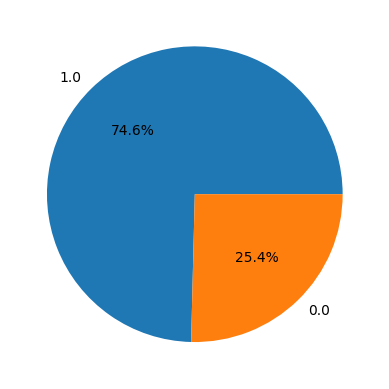

In [10]:
import matplotlib.pyplot as plt

x = df['class'].value_counts()
plt.pie(x.values,
        labels = x.index,
        autopct='%1.1f%%')
plt.show()

In [11]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

features = df.drop('class', axis=1)
target = df['class']

X_train, X_val,Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.2,
                                      random_state=10)

ros = RandomOverSampler(sampling_strategy=1.0,
                        random_state=0)
X, Y = ros.fit_resample(X_train, Y_train)
X.shape, Y.value_counts()

((302, 30),
 class
 1.0    151
 0.0    151
 Name: count, dtype: int64)

In [13]:
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score as ras

models = [LogisticRegression(class_weight='balanced'), SVC(kernel='rbf', probability=True)] 
for model in models:
    model.fit(X_train, Y_train)
    print(f'{model} : ')

    train_preds = model.predict(X_train)
    print('Training Accuracy : ', ras(Y_train, train_preds))

    val_preds = model.predict(X_val)
    print('Validation Accuracy : ', ras(Y_val, val_preds))
    print()

LogisticRegression(class_weight='balanced') : 
Training Accuracy :  0.7739072847682119
Validation Accuracy :  0.8301158301158301

SVC(probability=True) : 
Training Accuracy :  0.5566887417218543
Validation Accuracy :  0.5714285714285714



C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


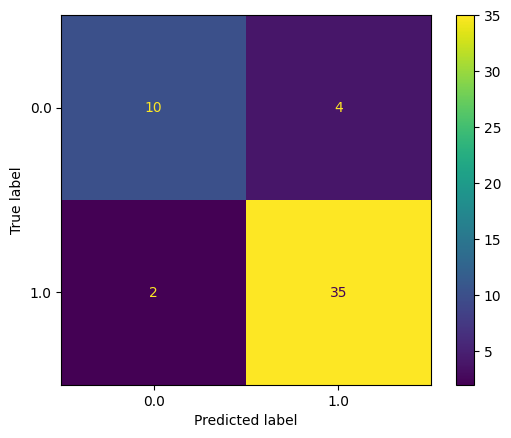

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[0], X_val, Y_val)
plt.show()